In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
fdata = pd.read_csv('data_histories.csv', index_col="dp_folio")
fdata.head()

,id_sexo,Aedad,AAedad,Apuesto,id_gestud,AIMC,fuma,fuma_act,ejer_act,ejer1,...,locout5,locout10,locout20,locout30,rest_act,rest1,rest5,rest10,rest20,rest30
dp_folio,,,,,,,,,,,,,,,,,,,,,
1,F,51,6,Admin,CarTec,4,1,3,0,2,...,1,1,1,1,0,0,0,0,0,0
2,F,38,4,Sec,Bach,3,2,-1,0,0,...,0,0,0,0,1,3,0,0,0,0
3,F,34,3,Int,Sec,5,1,1,0,0,...,1,-1,-1,-1,0,0,0,-1,-1,-1
4,M,63,8,Jef,CarTec,4,2,-1,2,2,...,0,0,0,-1,0,0,0,0,0,0
5,M,42,4,EM,Sec,3,1,2,2,2,...,0,0,0,0,0,0,0,0,0,0


In [3]:
class ProbModel:
    
    ##### FUNCTIONS FOR CLUSTERIZATION #####

    #Function to clusterize categories of a certain feature, and add the new clusterized feature as a new column
    # Clusters should be an input of the form {cluster_A: {categories}, cluster_B: [categories]}
    # Ex. obesity = {0:[1,2,3], 1:[4,5,6]}
    def clusterizeDiscrete(self, feature, clusters, new_name, data):
        new_data = data.copy()
        original_list = data.loc[data.index[0]:data.index[-1], feature]
        new_list = []
        for index in original_list.index:
            cat = False
            if original_list[index] == -1 or original_list[index] == "-1":
                new_list.append("N")
                continue
            for cluster in clusters:
                if original_list[index] in clusters[cluster]:
                    new_list.append(cluster)
                    cat = True
            if cat == False:
                new_list.append("N")
        new_data[new_name] = new_list
        return new_data

    # Function to clusterize categories of a certain continous feature, and add the new clusterized feature as a
    # new column
    # Clusters shoud be an input of the form {cluster_A: {lambdaFunction1}, cluster_B: lambdaFunction2}
    def clusterizeContinuous(self, feature, clusters, new_name, data):
        new_data = data.copy()
        original_list = data.loc[data.index[0]:data.index[-1], feature]
        new_list = []
        for index in original_list.index:
            if original_list[index] == -1 or original_list[index] == "-1":
                new_list.append("N")
                continue
            for cluster in clusters:
                if eval("self." + clusters[cluster])(original_list[index]):
                    new_list.append(cluster)
                    break
        new_data[new_name] = new_list
        return new_data

    # Set of auxiliary high-order functions that will evaluate the conditions to binarize a history
    def lessThan(self, num):
        return lambda n: n < num

    def lessQThan(self, num):
        return lambda n: n <= num

    def greaterThan(self, num):
        return lambda n: n > num

    def greaterQThan(self, num):
        return lambda n: n >= num

    def between(self, num1, num2):
        return lambda n: n <= num2 and n >= num1
    
    
    ##### FUNCTIONS FOR GROUPING VARIABLES #####

    # Function to build a composite random variable from several variables (to create a history, for example)
    def groupListOfVariables(self, list_of_features, new_name, data):
        new_data = data.copy()
        new_list = []
        i = 0
        for feature in list_of_features:
            buffer_list = data.loc[data.index[0]:data.index[-1], feature]
            if i == 0:
                for index in buffer_list.index:
                    new_list.append(str(buffer_list[index]))
                    i = i + 1
            else:
                k = 0
                for index in buffer_list.index:
                    new_list[k] = new_list[k] + str(buffer_list[index])
                    k = k + 1
        new_data[new_name] = new_list
        return new_data
    
    ##### FUNCTIONS FOR COUNTING / CALCULATING PROBABILITIES #####
    
    # Functions to count ocurrences for a category of a feature (NX)

    # Count the number of instances inside the database whose feature X = category
    # Ex: getNX('AIMC', 3, fdata)
    def getNX(self, feature, category, data):
        count = 0
        for index in data.index:
            if data.loc[index][feature] == category:
                count = count + 1
            elif self.matchStructure(data.loc[index][feature], category):
                count = count + 1
        return count

    # Count the number of instances inside the database whose feature X_1 = category_1 and feature X_2 = category_2
    # Ex: getNCX('AIMC', 3, 'Obesidad', 1, fdata)
    def getNCX(self, feature_1, category_1, feature_2, category_2, data):
        count = 0
        for index in data.index:
            if data.loc[index][feature_1] == category_1 and data.loc[index][feature_2] == category_2:
                count = count + 1
            elif self.matchStructure(data.loc[index][feature_1], category_1) and data.loc[index][feature_2] == category_2:
                count = count + 1
            elif self.matchStructure(data.loc[index][feature_1], category_1) and self.matchStructure(data.loc[index][feature_2], category_2):
                count = count + 1
            elif data.loc[index][feature_1] == category_1 and self.matchStructure(data.loc[index][feature_2], category_2):
                count = count + 1
        return count

    # Get a conditional probability P(F_1 = C_1 | F_2 = C_2)
    def getCondProb(self, feature_1, category_1, feature_2, category_2, data):
        ncx = self.getNCX(feature_1, category_1, feature_2, category_2, data)
        nx = self.getNX(feature_2, category_2, data)
        if nx != 0:
            p = ncx / float(nx)
        else:
            p = 0
        #return {'P': p, 'nx': nx, 'ncx': ncx}
        return p
    
    
    # Get the epsilon of a feature-category in relation to a classFeature-classCategory
    def getEpsilon(self, feature, category, classFeature, classCategory, data):
        n = len(data)
        nx = self.getNX(feature, category, data)
        nc = self.getNX(classFeature, classCategory, data)
        ncx = self.getNCX(feature, category, classFeature, classCategory, data)
        
        # Without smoothing
#         if n != 0 and nx != 0:
#             pc = nc / float(n)
#             pcx = ncx / float(nx)
#             epsilon = nx * (pcx - pc) / math.sqrt(nx * pc * (1 - pc))
#         else:
#             epsilon = 0

        # With smoothing
        pc = (nc + 1) / (float(n) + 2)
        pcx = (ncx + 1) / (float(nx) + 2)
        epsilon = nx * (pcx - pc) / math.sqrt(nx * pc * (1 - pc))
        
        #print 'Epsilon :' + str(epsilon)
        return {'feat': feature, 'cat': category, 'class': classFeature, 'classcat': classCategory, 'epsilon': epsilon, 'nx': nx, 'ncx': ncx, 'nc': nc}


    ##### FUNCTIONS FOR CALCULATING EPSILONS #####

    # Get the epsilons for all the categories in a single feature, in relation to a classFeature-classCategory
    def getAllEpsilons(self, feature, classFeature, classCategory, data):
        catlist = self.getCategories(feature, data)
        epsilons = []
        for category in catlist:
            epsilons.append(self.getEpsilon(feature, category, classFeature, classCategory, data))
        return pd.DataFrame(epsilons)

    # Get a list of all the categories that a single feature has in the dataset
    def getCategories(self, feature, data):
        index_list = data.loc[data.index[0]:data.index[-1], feature]
        categories = {}
        for index in index_list.index:
            categories[index_list[index]] = "1"
        return categories.keys()

    # Get the epsilons of a list of history patterns (categories), in relation to a classFeature-classCategory
    def getHistoriesEpsilons(self, feature, categories, classFeature, classCategory, data):
        epsilons = []
        for category in categories:
            epsilons.append(self.getEpsilon(feature, category, classFeature, classCategory, data))
        return epsilons

    # Get the epilons of a list of history patterns (histories), in relation to all the categories in classFeature 
    def getHistoriesEpsilonsLOC(self, feature, histories, classFeature, data):
        catlist = self.getCategories(classFeature, data)
        epsilons = []
        for category in catlist:
            epsilons = epsilons + self.getHistoriesEpsilons(feature, histories, classFeature, category, data)
        return pd.DataFrame(epsilons)
    
    
    ##### AUXILIARY FUNCTIONS #####
    
    # Function to determine if a certain history matches a general pattern
    def matchStructure(self, history, structure):
        if type(history) is str: 
            if len(history) != len(structure):
                return False
            for i in range(len(structure)):
                if history[i] != structure[i] and structure[i] != '*':
                    return False
            return True
        else:
            return False

    def stringGenerator(self, string, seeds, num):
        strings = []
        if num == 0:
            return string
        else:
            for seed in seeds:
                strings.append(stringGenerator(string + seed, seeds, num - 1))
        return strings

    def stringPadding(self, pre_padding, strings, post_padding):
        new_strings = []
        for string in strings:
            new_strings.append(pre_padding + string + post_padding)
        return new_strings

In [4]:
pm = ProbModel()

In [5]:
# Clusterize between obese and non obese
obesity = {0:[1,2,3], 1:[4,5,6]}
ndata = pm.clusterizeDiscrete("AIMC", obesity, "obesity", fdata)

# Clusterize excercise features
ejer = {"A":"greaterQThan(2.5)", "B":"lessThan(2.5)"}
ndata = pm.clusterizeContinuous("ejer_act", ejer, "ejer0B", ndata)
ndata = pm.clusterizeContinuous("ejer1", ejer, "ejer1B", ndata)
ndata = pm.clusterizeContinuous("ejer5", ejer, "ejer5B", ndata)
ndata = pm.clusterizeContinuous("ejer10", ejer, "ejer10B", ndata)
ndata = pm.clusterizeContinuous("ejer20", ejer, "ejer20B", ndata)
ndata = pm.clusterizeContinuous("ejer30", ejer, "ejer30B", ndata)

# Clusterize weight features
condi = {"A":[4,5], "B":[1,2,3]}
ndata = pm.clusterizeDiscrete("condi_act", condi, "condi0B", ndata)
ndata = pm.clusterizeDiscrete("condi1", condi, "condi1B", ndata)
ndata = pm.clusterizeDiscrete("condi5", condi, "condi5B", ndata)
ndata = pm.clusterizeDiscrete("condi10", condi, "condi10B", ndata)
ndata = pm.clusterizeDiscrete("condi20", condi, "condi20B", ndata)
ndata = pm.clusterizeDiscrete("condi30", condi, "condi30B", ndata)

ndata = pm.groupListOfVariables(["ejer0B", "ejer1B", "ejer5B", "ejer10B", "ejer20B", "ejer30B"], "ejerHistory", ndata)
ndata = pm.groupListOfVariables(["condi0B", "condi1B", "condi5B", "condi10B", "condi20B", "condi30B"], "condiHistory", ndata)

In [6]:
pm.getEpsilon("ejerHistory", "BB****", "obesity", 1, ndata)

{'feat': 'ejerHistory',
 'cat': 'BB****',
 'class': 'obesity',
 'classcat': 1,
 'epsilon': 3.1786428683595074,
 'nx': 509,
 'ncx': 137,
 'nc': 228}

In [105]:
class BayesianModel(ProbModel):
    
    # Get the score of a single feature-category in relation to a classFeature-classCategory
    def getScore(self, feature, category, classFeature, classCategory, data):
        n = len(data)
        nx = self.getNX(feature, category, data)
        nc = self.getNX(classFeature, classCategory, data)
        ncx = self.getNCX(feature, category, classFeature, classCategory, data)
        
        # Without smoothing
    #     pxc = ncx / float(nc)
    #     pxnc = (nx - ncx) / float(n - nc)
    #     if pxc != 0 and pxnc != 0:
    #         score = math.log(pxc/pxnc)
    #     else:
    #         score = 0
    
        # With smoothing
        pxc = (ncx + 1) / float(nc)
        pxnc = (nx - ncx + 1) / float(n - nc + 2)
        score = math.log(pxc/pxnc)
        return score

    
    ##### Score calculation, given a feature or a list of features #####
    ##### Only the features are explicitely stated; the categories are automatically extracted from the data ######
    
    # Get all the scores from all the feature-cagetory combinations of a list of features
    def getScoresFromFeatureList(self, list_of_features, classFeature, classCategory, data):
        scores = {}
        for feature in list_of_features:
            scores[feature] = self.getScoresFromFeature(feature, classFeature, classCategory, data)
        return scores
    
    # Get all the scores of the list of categories associated to a single feature
    def getScoresFromFeature(self, feature, classFeature, classCategory, data):
        catlist = self.getCategories(feature, data)
        scores = {}
        for category in catlist:
            scores[category] = self.getScore(feature, category, classFeature, classCategory, data)
        return scores
    
    
    ###### Score calculation, given a list of features and categories #####
    ###### Both the features and the categories are explicitly stated #####
    
    
    # Get all the scores associated to the feature and category combinations in the "queries" object
    # The "queries" object shoud have the following structure:
#     queries = {"feature1": ["category1", "category2" ..., "categoryM"],
#                "feature2": ["category1", "category2" ..., "categoryN"],
#                 .
#                 .
#                 .
#                "featureX": ["category1", "category2" ..., "categoryL"]
#               }
    def getScoresFromFeatureListAndCatlist(self, queries, classFeature, classCategory, data):
        scores = {}
        for feature in queries:
            scores[feature] = self.getScoresFromFeatureAndCatlist(feature, queries[feature], classFeature, classCategory, data)
        return scores

    # Get all the scores of the list of categories associated to a single feature
    def getScoresFromFeatureAndCatlist(self, feature, catlist, classFeature, classCategory, data):
        scores = {}
        for category in catlist:
            #scores.append(getScore(feature, category, classFeature, classCategory, data))
            scores[category] = self.getScore(feature, category, classFeature, classCategory, data)
        return scores
    
    
    ###### Scores - Full representation #####
    
    # Get the score of a single feature-category in relation to a classFeature-classCategory
    def getScoreFull(self, feature, category, classFeature, classCategory, data):
        n = len(data)
        nx = self.getNX(feature, category, data)
        nc = self.getNX(classFeature, classCategory, data)
        ncx = self.getNCX(feature, category, classFeature, classCategory, data)
    
        # Without smoothing
    #   pxc = ncx / float(nc)
    #   pxnc = (nx - ncx) / float(n - nc)
    #     if pxc != 0 and pxnc != 0:
    #         score = math.log(pxc/pxnc)
    #     else:
    #         score = 0
        
        # With smoothing
        pxc = (ncx + 1) / float(nc)
        pxnc = (nx - ncx + 1) / float(n - nc + 2)
        score = math.log(pxc / pxnc)
        
        return {'feat': feature, 'cat': category, 'class': classFeature, 'classcat': classCategory, 'score': score, 'nx': nx, 'ncx': ncx, 'nc': nc}


    # Get all the scores from all the feature-cagetory combinations of a list of features
    def getScoresFromFeatureListFull(self, list_of_features, classFeature, classCategory, data):
        scores = []
        for feature in list_of_features:
            scores = scores + self.getScoresFromFeatureFull(feature, classFeature, classCategory, data)
        return pd.DataFrame(scores)
    
    # Get all the scores of the list of categories associated to a single feature
    def getScoresFromFeatureFull(self, feature, classFeature, classCategory, data):
        catlist = self.getCategories(feature, data)
        scores = []
        for category in catlist:
            scores.append(self.getScoreFull(feature, category, classFeature, classCategory, data))
        return scores
    
    def getScoresFromFeatureListAndCatlistFull(self, queries, classFeature, classCategory, data):
        scores = []
        for feature in queries:
            scores = scores + self.getScoresFromFeatureAndCatlistFull(feature, queries[feature], classFeature, classCategory, data)
        return pd.DataFrame(scores)

    # Get all the scores of the list of categories associated to a single feature
    def getScoresFromFeatureAndCatlistFull(self, feature, catlist, classFeature, classCategory, data):
        scores = []
        for category in catlist:
            #scores.append(getScore(feature, category, classFeature, classCategory, data))
            scores.append(self.getScoreFull(feature, category, classFeature, classCategory, data))
        return scores
    
    
    ##### Auxiliary functions for the actual implementation of the above functions in a classification model
    
    # Use the scores dictionary to replace the individual scores in the original data
    def getScoresFromFLPerUser(self, query_features, scores_dictionary, data):
        user_data = data[query_features]
        for index in user_data.index:
            for col in user_data.columns:
                category = user_data.at[index, col]
                feature = col
                try:
                    user_data.at[index, col] = scores_dictionary[feature][category]
                except:
                    print("The score for a feature-category combination was not set - It may have not been in the training set")
                    print("The score for index " + str(index) + " will be set to 0")
                    user_data.at[index, col] = 0
        return user_data
    
    def getScoresFromFLCLPerUser(self, queries, scores_dictionary, data):
        query_features = queries.keys()
        user_data = data[query_features]
        for index in user_data.index:
            for col in user_data.columns:
                category = user_data.at[index, col]
                feature = col
                try:
                    user_data.at[index, col] = scores_dictionary[feature][category]
                except:
                    print("The score for a feature-category combination was not set - It may have not been in the training set")
                    print("The score for index " + str(index) + " will be set to 0")
                    user_data.at[index, col] = 0
        return user_data


In [96]:
ndata[queries.keys()]

,ejer0B,condi0B
dp_folio,,
1,B,B
2,B,A
3,B,B
4,B,B
5,B,B
...,...,...
1076,B,B
1077,A,B
1078,B,A


In [41]:
bm = BayesianModel()

In [226]:
bm.getScore("ejerHistory", "BB****", "obesity", 1, ndata)

0.3215659860433105

In [227]:
bm.getScoreFull("ejerHistory", "BB****", "obesity", 1, ndata)

{'feat': 'ejerHistory',
 'cat': 'BB****',
 'class': 'obesity',
 'classcat': 1,
 'score': 0.3215659860433105,
 'nx': 509,
 'ncx': 137,
 'nc': 228}

In [228]:
bm.getScoresFromFeatureFull("ejer0B", "obesity", 1, ndata)

[{'feat': 'ejer0B',
  'cat': 'B',
  'class': 'obesity',
  'classcat': 1,
  'score': 0.2875179272376132,
  'nx': 651,
  'ncx': 171,
  'nc': 228},
 {'feat': 'ejer0B',
  'cat': 'A',
  'class': 'obesity',
  'classcat': 1,
  'score': -0.5518546556760557,
  'nx': 424,
  'ncx': 56,
  'nc': 228},
 {'feat': 'ejer0B',
  'cat': 'N',
  'class': 'obesity',
  'classcat': 1,
  'score': 2.009037901089867,
  'nx': 1,
  'ncx': 1,
  'nc': 228}]

In [231]:
bm.getScoresFromFeatureList(query_features_nba, "obesity", 1, ndata)

{'ejer0B': {'B': 0.2875179272376132,
  'A': -0.5518546556760557,
  'N': 2.009037901089867},
 'ejer1B': {'B': 0.2818169529993828,
  'A': -0.4708812071870944,
  'N': 2.702185081649812}}

In [232]:
bm.getScoresFromFeatureListFull(query_features_nba, "obesity", 1, ndata)

,feat,cat,class,classcat,score,nx,ncx,nc
0,ejer0B,B,obesity,1,0.287518,651,171,228
1,ejer0B,A,obesity,1,-0.551855,424,56,228
2,ejer0B,N,obesity,1,2.009038,1,1,228
3,ejer1B,B,obesity,1,0.281817,608,159,228
4,ejer1B,A,obesity,1,-0.470881,465,66,228
5,ejer1B,N,obesity,1,2.702185,3,3,228


In [9]:
query_features_nba = ["ejer0B", "ejer1B"]
score_dic = bm.getScoresFromFeatureList(["ejer0B", "ejer1B"], "obesity", 1, ndata)

In [42]:
bm.getScoresFromFLPerUser(["ejer0B", "ejer1B"], score_dic, ndata)

,ejer0B,ejer1B
dp_folio,,
1,0.287518,0.281817
2,0.287518,0.281817
3,0.287518,0.281817
4,0.287518,0.281817
5,0.287518,0.281817
...,...,...
1076,0.287518,0.281817
1077,-0.551855,-0.470881
1078,0.287518,-0.470881


In [10]:
# Libraries for ROC plots
from scipy import interp
from sklearn.metrics import roc_curve, auc

# Libraries for Cross Validation
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import KFold

In [106]:
class NBA(BayesianModel):
    
    # Class constructor
    def __init__(self):
        self.scores_dictionary = {}
        self.predicted_scores = {}
        self.query_features = {}
        self.classFeature = ""
        self.classCategory = ""
    
    # Train the model, given certain query_features, a classFeature-classCategory and some training data Xt
    def train(self, query_features, classFeature, classCategory, Xt):
        # Get the dictionary of scores, in relation to classFeature-classCategory
        self.query_features = query_features
        self.classFeature = classFeature
        self.classCategory = classCategory
        self.scores_dictionary = self.getScoresFromFeatureList(self.query_features, self.classFeature, self.classCategory, Xt)
    
    # Use the scores dictionary of the already trained model to classify the test data Xv
    def predict(self, Xv):

        # Use the dictionary of scores to calculate the associated sum of scores for every user
        user_scores = self.getScoresFromFLPerUser(self.query_features, self.scores_dictionary, Xv)
        
        # Store all the score-related information in a dataframe
        sum_scores = pd.DataFrame(user_scores.sum(axis=1))
        user_scores = user_scores.join(sum_scores)
        user_scores = user_scores.rename(columns={0: "total_score"})
        self.predicted_scores = user_scores.copy()
    
    # Use the scores dictionary of the already trained model to predict the scores of the test data Xv
    def get_predicted_scores(self):
        # Return the predicted scores from the self.predicted_scores table
        return pd.DataFrame(self.predicted_scores["total_score"])
    
    # Use the scores dictionary of the already trained model to perform a classification of the test data Xv
    def get_predicted_labels(self):
        # Evaluate whether the total_score > 0. Classify as 1 if total_score > 0, or 0 if total_score <= 0
        labels = pd.DataFrame(self.predicted_scores.eval('total_score > 0').replace(True, 1).replace(False, 0))
        label_name = "predicted_" + self.classFeature
        return labels.rename(columns={0: label_name})

In [45]:
nba = NBA()

In [46]:
nba.train(query_features_nba, "obesity", 1, ndata)

In [47]:
nba.predict(ndata)

In [48]:
nba.get_predicted_scores()

,total_score
dp_folio,
1,0.569335
2,0.569335
3,0.569335
4,0.569335
5,0.569335
...,...
1076,0.569335
1077,-1.022736
1078,-0.183363


In [49]:
nba.get_predicted_labels()

,predicted_obesity
dp_folio,
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
...,...
1076,1.0
1077,0.0
1078,0.0


In [17]:
def getScoresFromFeatureListAndCatlist(queries, classFeature, classCategory, data):
    scores = {}
    for feature in queries:
        scores[feature] = getScoresFromFeatureAndCatlist(feature, queries[feature], classFeature, classCategory, data)
    return scores

# Get all the scores of the list of categories associated to a single feature
def getScoresFromFeatureAndCatlist(feature, catlist, classFeature, classCategory, data):
    scores = {}
    for category in catlist:
        #scores.append(getScore(feature, category, classFeature, classCategory, data))
        scores[category] = bm.getScore(feature, category, classFeature, classCategory, data)
    return scores

In [62]:
# queries = {"ejerHistory": ["AAAAAA", "BBBBBB"],
#            "condiHistory": ["AAAAAA", "BBBBBB"]
#           }
queries = {"ejer0B": ["A", "B", "N"],
          "condi0B": ["A", "B", "N"]
          }

In [217]:
for query in queries:
    print(query)
    print(queries[query])

ejerHistory
['AAAAAA', 'BBBBBB']
condiHistory
['AAAAAA', 'BBBBBB']


In [19]:
bm.getScoresFromFeatureListAndCatlistFull(queries, "obesity", 1, ndata)

,feat,cat,class,classcat,score,nx,ncx,nc
0,ejerHistory,AAAAAA,obesity,1,-0.668241,89,10,228
1,ejerHistory,BBBBBB,obesity,1,0.271346,144,37,228
2,condiHistory,AAAAAA,obesity,1,-0.475869,180,25,228
3,condiHistory,BBBBBB,obesity,1,0.622744,40,13,228


In [20]:
bm.getScoresFromFeatureListAndCatlist(queries, "obesity", 1, ndata)

{'ejerHistory': {'AAAAAA': -0.6682406413455897, 'BBBBBB': 0.27134565313208747},
 'condiHistory': {'AAAAAA': -0.4758687486981336, 'BBBBBB': 0.6227435399699759}}

In [107]:
class GNB(BayesianModel):
    
    # Class constructor
    def __init__(self):
        self.scores_dictionary = {}
        self.predicted_scores = {}
        self.queries = {}
        self.classFeature = ""
        self.classCategory = ""
    
    # Train the model, given certain query_features, a classFeature-classCategory and some training data Xt
    def train(self, queries, classFeature, classCategory, Xt):
        # Get the dictionary of scores, in relation to classFeature-classCategory
        self.queries = queries
        self.classFeature = classFeature
        self.classCategory = classCategory
        self.scores_dictionary = self.getScoresFromFeatureListAndCatlist(self.queries, self.classFeature, self.classCategory, Xt)
    
    # Use the scores dictionary of the already trained model to classify the test data Xv
    def predict(self, Xv):

        # Use the dictionary of scores to calculate the associated sum of scores for every user
        user_scores = self.getScoresFromFLCLPerUser(self.queries, self.scores_dictionary, Xv)
        
        # Store all the score-related information in a dataframe
        sum_scores = pd.DataFrame(user_scores.sum(axis=1))
        user_scores = user_scores.join(sum_scores)
        user_scores = user_scores.rename(columns={0: "total_score"})
        self.predicted_scores = user_scores.copy()
    
    # Use the scores dictionary of the already trained model to predict the scores of the test data Xv
    def get_predicted_scores(self):
        # Return the predicted scores from the self.predicted_scores table
        return pd.DataFrame(self.predicted_scores["total_score"])
    
    # Use the scores dictionary of the already trained model to perform a classification of the test data Xv
    def get_predicted_labels(self):
        # Evaluate whether the total_score > 0. Classify as 1 if total_score > 0, or 0 if total_score <= 0
        labels = pd.DataFrame(self.predicted_scores.eval('total_score > 0').replace(True, 1).replace(False, 0))
        label_name = "predicted_" + self.classFeature
        return labels.rename(columns={0: label_name})

In [57]:
gnb = GNB()

In [63]:
gnb.train(queries, "obesity", 1, ndata)

In [64]:
gnb.scores_dictionary

{'ejer0B': {'A': -0.5518546556760557,
  'B': 0.2875179272376132,
  'N': 2.009037901089867},
 'condi0B': {'A': -0.7393235258145903,
  'B': 0.34950960326558106,
  'N': 0.2172784318618115}}

In [65]:
gnb.predict(ndata)

In [67]:
gnb.get_predicted_scores()

,total_score
dp_folio,
1,0.637028
2,-0.451806
3,0.637028
4,0.637028
5,0.637028
...,...
1076,0.637028
1077,-0.202345
1078,-0.451806


In [69]:
gnb.get_predicted_labels()

,predicted_obesity
dp_folio,
1,1.0
2,0.0
3,1.0
4,1.0
5,1.0
...,...
1076,1.0
1077,0.0
1078,0.0


In [109]:
class Validation:
    
    def __init__(self, model):
        self.model = model
        self.model_type = type(model).__name__
        
    # Run a CV of the GNB model and perform a decile analysis of its results
    def runCV(self, X, qF, cF, cC, folds, plot_name):

        kf = KFold(n_splits = 5, shuffle=True)

        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        sum_actual_tps = np.repeat(0.0, 10)
        sum_expected_tps = np.repeat(0.0, 10)

        j = 0
        for train_index, test_index in kf.split(X):
            train = pd.DataFrame()
            test = pd.DataFrame()
            for index in train_index:
                name = X.iloc[index].name
                train = train.append(X.loc[name])
            for index in test_index:
                name = X.iloc[index].name
                test = test.append(X.loc[name])

            self.model.train(qF, cF, cC, train)
            self.model.predict(test)
            Yprob = self.model.get_predicted_scores()

            fpr, tpr, thresholds = roc_curve(test[cF].values, Yprob.values[:, -1])
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            plt.plot(fpr, tpr, lw=1, alpha=0.3, label="ROC fold %d (AUC=%0.2f)" % (j + 1, roc_auc))
            j = j + 1

            # Decile analysis
            scores = Yprob.copy()
            scores[cF] = test[cF]
            bins = self.splitScores(scores, 10)
            actual_tps = self.getDecileFrequencies(bins, cF)      
            expected_tps = self.getExpectedTPs(scores, cF, 10)

            sum_actual_tps += actual_tps
            sum_expected_tps += expected_tps

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        plt.plot(mean_fpr, mean_tpr, lw=2, color='b', alpha=0.8, label='Mean ROC (AUC=%0.2f)' % (mean_auc))
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.title(plot_name)
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
               label='Random', alpha=.8)
        plt.legend(loc="lower right")
        plt.show()

        # Plot the results of the decile analysis
        mean_actual_tps = sum_actual_tps / (folds * 1.0)
        mean_expected_tps = sum_expected_tps / (folds * 1.0)
        self.plotDecileBars(mean_actual_tps, mean_expected_tps, 10)
        
    # Function to plot the score distribution of the classified data, by deciles
    def plotScoreDistribution(self, scores, classFeature, num_bins):
        # Sort by score and split the data into buckets (deciles)
        bins = self.splitScores(scores, num_bins)

        # Get the number of true positives by decile
        frequencies = self.getDecileFrequencies(bins, classFeature)

        # Get the expected value of true positives by decile, if the classification was made randomly
        expected = self.getExpectedTPs(scores, classFeature, num_bins)

        # Plot the results
        self.plotDecileBars(frequencies, expected, num_bins)

    # Split the scores dataframe in bins
    def splitScores(self, scores, num_bins):
        results = scores.copy()
        sorted_results = results.sort_values(by=["total_score"], ascending=False)
        bins = np.array_split(sorted_results, num_bins)
        return bins

    # Get the count of true positives for every bin
    def getDecileFrequencies(self, bins, classFeature):
        frequencies = []
        for binid in range(len(bins)):
            frequencies.append(bins[binid][classFeature].sum())
        return frequencies

    # Get the expected count of true positives per decile
    def getExpectedTPs(self, scores, classFeature, num_bins):
        expected = np.repeat(scores[classFeature].sum(), num_bins) * 1.0 / num_bins
        return expected

    # Plot the results
    def plotDecileBars(self, frequencies, expected, num_bins):
        plt.bar(np.arange(1, num_bins + 1, 1), frequencies, color='b', label="Actual True Positives")
        plt.plot(np.arange(1, num_bins + 1, 1), expected, color='r', linestyle='dashed', label="Expected True Positives")
        plt.legend(loc="upper right")
        plt.xlabel("Score Decile")
        plt.ylabel("# of True Positives")
        plt.title("True Positives Distribution")
        plt.show()

In [110]:
validation = Validation(NBA())

The score for a feature-category combination was not set - It may have not been in the training set
The score for index 109 will be set to 0


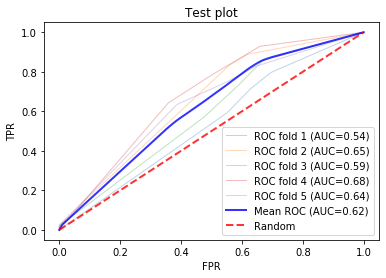

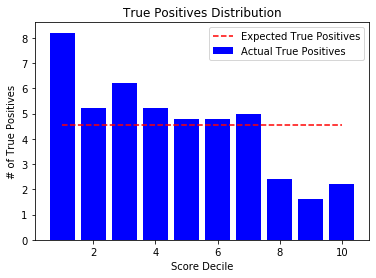

In [111]:
validation.runCV(ndata, query_features_nba, "obesity", 1, 5, "Test plot")

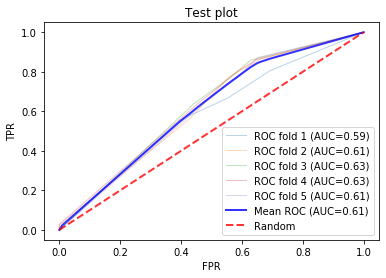

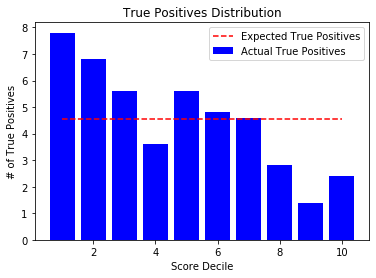

In [85]:
validation.runCV(ndata[(ndata.ejer0B != "N") & (ndata.condi0B != "N")], query_features_nba, "obesity", 1, 5, "Test plot")

In [115]:
validation = Validation(GNB())

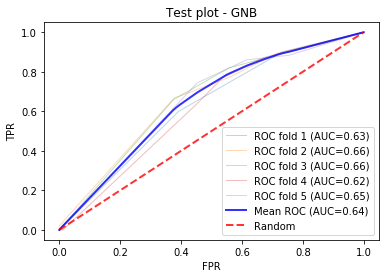

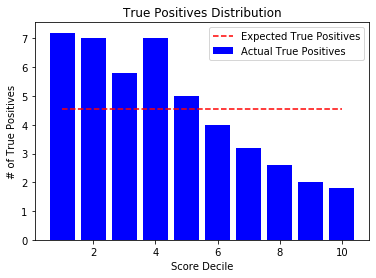

In [116]:
validation.runCV(ndata, queries, "obesity", 1, 5, "Test plot - GNB")